# Comparing SSA Instruments

**Goal**: Find colocated SSA measurements with more than one instrument and compare by plotting, this is replicating the plot found in the 
meta.pdf that came with the data

**Approach**:

1. Find all sites with SSA data 
2. Isolate the sites with multiple SSA instruments 
3. Plot each site with all its instruments we found


## Process

### Step 1: Find all the Sites that have SSA Data

In [1]:
from snowxsql.db import get_db
from snowxsql.data import LayerData, PointData
from snowxsql.conversions import points_to_geopandas, query_to_geopandas

import geoalchemy2.functions as gfunc
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Connect to the database we made.
db_name = 'snowex'
engine, session = get_db(db_name)

# Grab all the equivalent diameter profiles
q = session.query(LayerData).filter(LayerData.type == 'specific_surface_area')
df = query_to_geopandas(q, engine)

# End our database session to avoid hanging transactions
session.close()

# Grab all the sites with equivalent diameter data (set reduces a list to only its unique entries)
sites = df['site_id'].unique()

### Step 2: Isolate all the Sites with Multiple SSA Instruments

In [2]:
# Store all site names that have mulitple SSA instruments
multi_instr_sites = []
instruments = []

for site in sites:

    # Grab all the layers associated to this site
    site_data = df.loc[df['site_id'] == site]

    # Do a set on all the instruments used here
    instruments_used = site_data['instrument'].unique()

    if len(instruments_used) > 1:
        multi_instr_sites.append(site)

# Get a unqique list of SSA instruments that were colocated
instruments = df['instrument'].unique()

### Step 3: Plot all SSA profiles at all Multi-Instrumented Sites

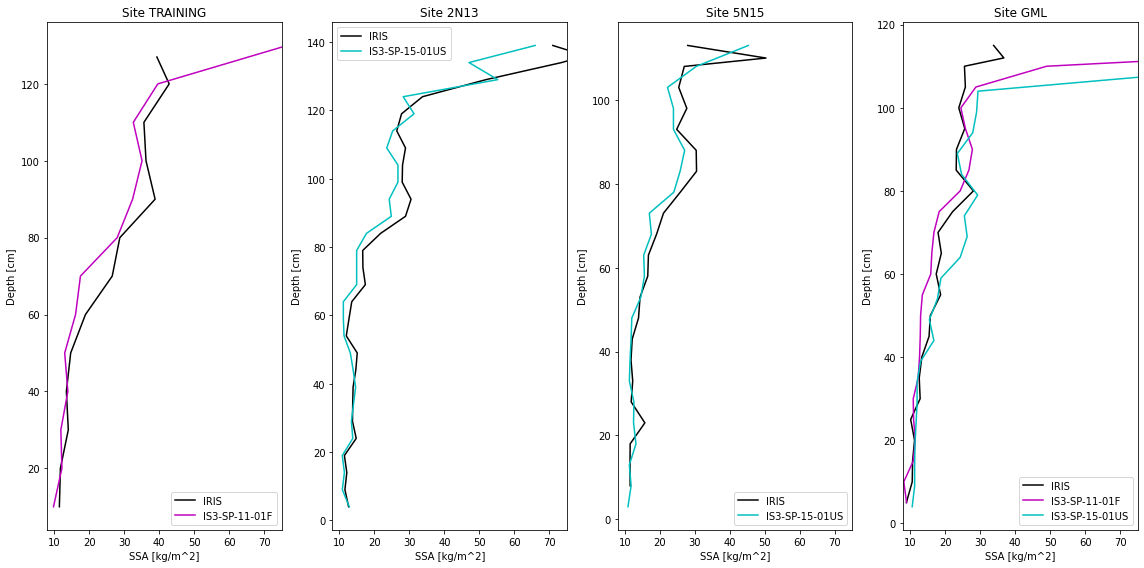

In [3]:
# Setup the subplot for each site for each instrument
fig, axes = plt.subplots(1, len(multi_instr_sites), figsize=(4*len(multi_instr_sites), 8))

# Establish plot colors unique to the instrument
c = ['k', 'm', 'c']
colors = {inst:c[i] for i,inst in enumerate(instruments)}

# Loop over all the multi-instrument sites 
for i, site in enumerate(multi_instr_sites):
    
    # Grab the plot for this site
    ax = axes[i]
    
    # Loop over all the instruments at this site
    for instr in instruments:

        # Grab our profile by site and instrument
        ind = df['site_id'] == site 
        ind2 = df['instrument'] == instr
        profile = df.loc[ind & ind2].copy()

        # Don't plot it unless there is data
        if len(profile.index) > 0:
            
            # Sort by depth so samples that are take out of order won't mess up the plot
            profile = profile.sort_values(by='depth')
            
            # Layer profiles are always stored as strings. 
            profile['value'] = profile['value'].astype(float)
            
            # Plot our profile
            ax.plot(profile['value'], profile['depth'], colors[instr], label=instr)
   
    # Labeling and plot style choices
    ax.legend()
    ax.set_xlabel('SSA [kg/m^2]')
    ax.set_ylabel('Depth [cm]')
    ax.set_title('Site {}'.format(site.upper()))
    
    # Set the x limits to show more detail
    ax.set_xlim((8, 75))
    
plt.tight_layout()
plt.show()